<a href="https://colab.research.google.com/github/amthreeh/-AI-SPARK-air_compressor/blob/main/autoencoder_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [3]:
# train 데이터 불러오기
train_data = pd.read_csv('drive/MyDrive/공기압축기/train_data.csv')

features = ['air_inflow', 'air_end_temp', 'out_pressure', 'motor_current', 'motor_rpm', 'motor_temp', 'motor_vibe']

# 특성 변수를 정규화하여 X 데이터로 만들기
scaler = StandardScaler()
X_train = scaler.fit_transform(train_data[features])

In [4]:
from keras.layers import Input, Dense
from keras.models import Model

# 입력층
input_layer = Input(shape=(len(features),))

# 인코더
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)
encoded = Dense(8, activation='relu')(encoded)


# 디코더
decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(decoded)
decoded = Dense(len(features), activation=None)(decoded)

# Autoencoder 모델
autoencoder = Model(input_layer, decoded)

# 인코더 모델
encoder = Model(input_layer, encoded)


In [5]:
from keras.optimizers import Adam
autoencoder.compile(optimizer=Adam(lr=0.001), loss='mse')
autoencoder.fit(X_train, X_train, epochs=100, batch_size=17, validation_split=0.3)


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
102/102 [==============================] - 2s 11ms/step - loss: 0.4898 - val_loss: 0.0123
Epoch 2/100
102/102 [==============================] - 1s 6ms/step - loss: 0.0565 - val_loss: 0.0030
Epoch 3/100
102/102 [==============================] - 1s 12ms/step - loss: 0.0042 - val_loss: 0.0012
Epoch 4/100
102/102 [==============================] - 1s 10ms/step - loss: 0.0033 - val_loss: 6.4085e-04
Epoch 5/100
102/102 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 2.3432e-04
Epoch 6/100
102/102 [==============================] - 1s 11ms/step - loss: 8.3348e-04 - val_loss: 3.4255e-04
Epoch 7/100
102/102 [==============================] - 1s 6ms/step - loss: 7.9511e-04 - val_loss: 3.3058e-04
Epoch 8/100
102/102 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 1.9734e-04
Epoch 9/100
102/102 [==============================] - 1s 5ms/step - loss: 6.3026e-04 - val_loss: 3.0558e-04
Epoch 10/100
102/102 [============================

77/77 [==============================] - 0s 1ms/step


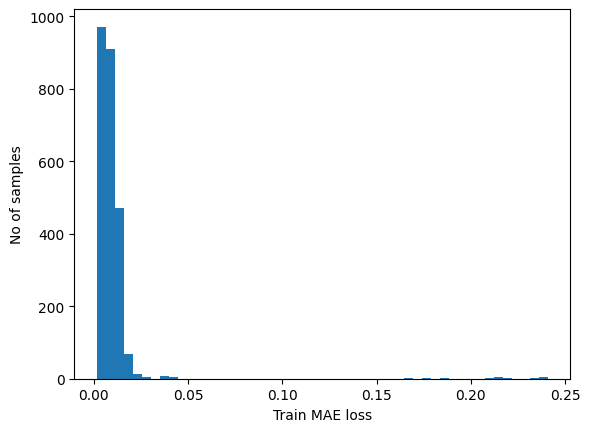

231/231 [==============================] - 0s 1ms/step


In [6]:
# train 데이터의 재구성 오차 구하기
X_train_pred = autoencoder.predict(X_train)
train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['mae_loss'])
train_mae_loss.describe()

# 재구성 오차의 분포 시각화
import matplotlib.pyplot as plt
plt.hist(train_mae_loss['mae_loss'], bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('No of samples')
plt.show()

# 재구성 오차의 임계치 설정하기
threshold = train_mae_loss.quantile(0.99)['mae_loss']

# test 데이터 불러오기 및 전처리
test_data = pd.read_csv('drive/MyDrive/공기압축기/test_data.csv')
X_test = scaler.transform(test_data[features])

# test 데이터에 대한 예측
X_test_pred = autoencoder.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

# 이상치 판단하기
test_data['anomaly'] = test_mae_loss > threshold
anomalies = test_data.loc[test_data['anomaly'] == True]


In [7]:
# label 작성하기
test_data['label'] = test_data['anomaly'].apply(lambda x: 1 if x else 0)

# answer_sample.csv 파일로 저장하기
test_data[['type', 'label']].to_csv('answer_sample.csv', index=False)
